## Maintenance contract

Here we test the evolution of our segmentation through time. 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_rows" , 500)
pd.set_option("display.max_columns" , 500)

#Load csv files
PATH = "F:\Work\OpenClassroomML\Projet4\data"

df = pd.read_csv(os.path.join(PATH, "groupeddf.csv"),
                 encoding = 'utf8',
                 sep =',',
                 low_memory = False)

refdf = pd.read_csv(os.path.join(PATH, "refgroupeddf.csv"),
                    encoding = 'utf8',
                    sep = ',',
                    low_memory = False)




In [2]:
def get_old_clients(max_recency,
                    PATH):
        
    """Get the cleaned dataset has it would be at recency time (light version of original data cleaning without scaling)

    Positional arguments : 
    -----------------------------------
    max_recency : number of days between the first order and the desired dataset state in days
    PATH : os.path to original dataset files
    """

    #load csv files

    customerdf = pd.read_csv(os.path.join(PATH, "olist_customers_dataset.csv"),
                             encoding = 'utf8',
                             sep = ',',
                             low_memory = False)

    geolocationdf = pd.read_csv(os.path.join(PATH, "olist_geolocation_dataset.csv"),
                                encoding = 'utf8',
                                sep = ',',
                                low_memory = False)

    itemsdf = pd.read_csv(os.path.join(PATH, "olist_order_items_dataset.csv"),
                          encoding = 'utf8',
                          sep = ',',
                          low_memory = False)

    paymentsdf = pd.read_csv(os.path.join(PATH, "olist_order_payments_dataset.csv"),
                             encoding = 'utf8',
                             sep = ',',
                             low_memory = False)

    reviewsdf = pd.read_csv(os.path.join(PATH, "olist_order_reviews_dataset.csv"),
                            encoding = 'utf8',
                            sep = ',',
                            low_memory = False)

    ordersdf = pd.read_csv(os.path.join(PATH, "olist_orders_dataset.csv"),
                           encoding = 'utf8',
                           sep = ',',
                           low_memory = False)

    productsdf = pd.read_csv(os.path.join(PATH, "olist_products_dataset.csv"),
                             encoding = 'utf8',
                             sep = ',',
                             low_memory = False)

    sellersdf = pd.read_csv(os.path.join(PATH, "olist_sellers_dataset.csv"),
                            encoding = 'utf8',
                            sep = ',',
                            low_memory = False)

    translationdf = pd.read_csv(os.path.join(PATH, "product_category_name_translation.csv"),
                                encoding = 'utf8',
                                sep = ',',
                                low_memory = False)


    #dropping duplicates as geolocationdf is supposed to be a dictionary
    geolocationdf = geolocationdf.drop_duplicates(subset=['geolocation_zip_code_prefix']).reset_index(drop=True)



    #Group data on order_id
    paymentsdf = paymentsdf.groupby(['order_id']).agg(
        total_payment= ('payment_value', 'sum')
        )


    #Dopping non rated orders
    reviewsdf = reviewsdf.dropna(subset=['review_score'])

    #Group data on order_id
    reviewsdf = reviewsdf.groupby(['order_id']).agg(
        mean_review_score= ('review_score', 'mean')
        )

    #merge auxiliary datasets
    tempdf1 = sellersdf.merge(geolocationdf,
                              how = 'left',
                              left_on = 'seller_zip_code_prefix',
                              right_on = 'geolocation_zip_code_prefix')

    tempdf1 = tempdf1.rename(columns = {'geolocation_lat':'seller_geolocation_lat',
                                        'geolocation_lng':'seller_geolocation_lng',
                                        'geolocation_city':'seller_geolocation_city',
                                        'geolocation_state':'seller_geolocation_state'})

    tempdf2 = itemsdf.merge(productsdf,how = 'left', on = 'product_id')
    tempdf2 = tempdf2.merge(tempdf1,how = 'left', on = 'seller_id')
    tempdf2 = tempdf2.merge(translationdf,how = 'left', on = 'product_category_name')

    tempdf3 = customerdf.merge(geolocationdf,
                               how ='left',
                               left_on = 'customer_zip_code_prefix',
                               right_on = 'geolocation_zip_code_prefix')

    tempdf3 = tempdf3.rename(columns = {'geolocation_lat':'customer_geolocation_lat',
                                        'geolocation_lng':'customer_geolocation_lng',
                                        'geolocation_city':'customer_geolocation_city',
                                        'geolocation_state':'customer_geolocation_state'})



    #Merging main dataset
    df = pd.DataFrame()
    df = ordersdf.merge(paymentsdf,how = 'left', on = 'order_id')
    df = df.merge(reviewsdf,how = 'left', on = 'order_id')
    df = df.merge(tempdf3,how = 'left', on = 'customer_id')

    #Dopping non deliverded orders
    df = df.drop(df.loc[df.order_status != "delivered"].index)

    #extracting recency
    minrecencydatetime  = pd.to_datetime(df['order_purchase_timestamp']).min()
    df["recency"] = (pd.to_datetime(df['order_purchase_timestamp'])-minrecencydatetime).dt.total_seconds()
    
    """
    #isolating frequent customers
    frequent_customers = df.groupby(['customer_unique_id']).agg(
        frequency = ('total_payment', 'count'))
    
    frequent_customers = frequent_customers.drop(frequent_customers.loc[frequent_customers["frequency"] < 2].index)
    
    """

    #Dropping null values
    intcol = ["total_payment",
              'mean_review_score',
              "recency"]

    df = df.dropna(subset = intcol)
    
    #Dopping order more recent than max_recency
    max_recency = max_recency*60*60*24
    df = df.drop(df.loc[df["recency"] > max_recency].index)

    #Groupping features on unique customers :
    groupeddf = df.groupby(['customer_unique_id']).agg(
        mean_review_score = ('mean_review_score', 'mean'),
        recency = ('recency', 'max'),
        frequency = ('total_payment', 'count'),
        monetary = ('total_payment', 'sum')
        )

    #recency from seconds to days
    groupeddf["recency"] = groupeddf["recency"]/(60*60*24)
    
    return groupeddf

In [3]:
df

,customer_unique_id,mean_delivery_time,mean_review_answer_time,review_comment_message_number,payment_sequential,mean_cash_payment,mean_credit_card_payment,mean_debit_card_payment,mean_voucher_payment,mean_undefined_payment,mean_review_score,customer_city_mostfrequent,customer_state_mostfrequent,seller_city_mostfrequent,seller_state_mostfrequent,product_category_name_mostfrequent,mean_seller_customer_distance,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.645648,0.144298,1.109844,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,cajamar,SP,piracicaba,SP,bed_bath_table,-0.076934,0.821999,-0.159188,-0.102842
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.976334,-0.226073,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,osasco,SP,sao paulo,SP,health_beauty,-0.269384,0.802413,-0.159188,-0.612386
2,0000f46a3911fa3c0805444483337064,1.398429,-0.214024,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.903062,sao jose,SC,campo limpo paulista,SP,stationery,0.189587,-1.966107,-0.159188,-0.350173
3,0000f6ccb0745a6a4b88665a16c9f078,0.795943,-0.218402,1.109844,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,belem,PA,sao paulo,SP,telephony,2.364572,-0.551177,-0.159188,-0.539403
4,0004aac84e0df4da2b147fca70cf8255,0.066364,0.181424,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sorocaba,SP,jacarei,SP,telephony,-0.081250,-0.335182,-0.159188,0.141424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91022,fffcf5a5ff07b0908bd4e2dbc735a684,1.587078,0.134061,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sanharo,PE,sao paulo,SP,health_beauty,-0.678507,-1.376506,-0.159188,8.450347
91023,fffea47cd6d3cc0a88bd621562a9d061,1.860316,0.238188,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,-0.121110,feira de santana,BA,laranjal paulista,SP,baby,-0.910643,-0.164746,-0.159188,-0.357458
91024,ffff371b4d645b6ecea244b27531430a,0.249495,-0.053887,-0.807772,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,sinop,MT,belo horizonte,MG,auto,2.900129,-2.170636,-0.159188,-0.233615
91025,ffff5962728ec6157033ef9805bacc48,-0.069299,-0.052968,1.109844,-0.122949,-0.499671,0.575042,-0.125694,-0.187125,0.0,0.660843,bom jesus do norte,ES,ribeirao preto,SP,watches_gifts,-0.787575,0.770776,-0.159188,-0.139311


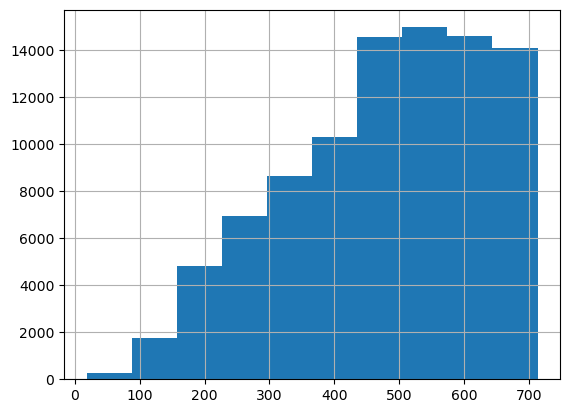

In [4]:
hist = refdf["recency"].hist(bins = 10)

In [5]:
round(refdf["recency"].median(axis = 0))


495

In [6]:
round(refdf["recency"].quantile(q = 0.10))


248

To test the evolution of our clustering we go back in time where we already had 10% of our customers (248 days after the first entry of the dataset). With those ancient data we perform the previously choosen clustering and use it to predict clusters on increasingly more recent dataset by including more recent orders and comparing the adjusted rand index (ARI).

Text(0, 0.5, 'Silhouette Coefficient')

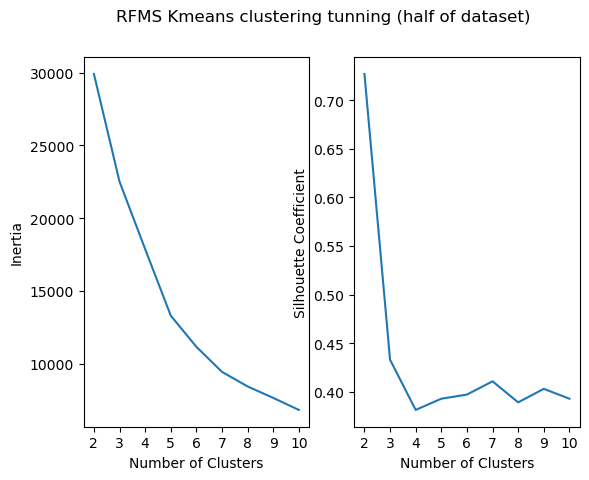

In [7]:
#Finding simulation boundaries
medrecency = round(refdf["recency"].quantile(q = 0.10))
maxrecency = round(refdf["recency"].max(axis = 0))


meddf = get_old_clients(max_recency = medrecency,
                                 PATH = PATH)

#scaling data
scaler = StandardScaler()
meddf.loc[:,:] = scaler.fit_transform(meddf)

meddata = meddf.values

# A list holds the inertia values for each k
inertia = []
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

range_ = range(2, 11)

for k in range_:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(meddata)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(meddata, kmeans.labels_,sample_size = 10000,random_state=42)
    silhouette_coefficients.append(score)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('RFMS Kmeans clustering tunning (half of dataset)')


ax1.plot(range_, inertia)
ax1.set_xticks(range_)
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia")

ax2.plot(range_, silhouette_coefficients)
ax2.set_xticks(range_)
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Coefficient")






We can see here taking half oh the data change the optimal segmentation we could do but we stick to our previous parameters.

Now the simulation itslef :

In [8]:
# A list holds the inertia values for each k
ARI = []
timerange = np.arange(0, maxrecency-medrecency, 10)

#Fitting and predicting reference clustering
kmeansmed = KMeans(n_clusters=5, random_state=42)
kmeansmed.fit(meddata)
clustermed = kmeansmed.predict(meddata)

for time in timerange:
        
    dftemp = get_old_clients(max_recency = time+medrecency,
                                 PATH = PATH)
    
    #scaling data with previous scaler
    dftemp.loc[:,:] = scaler.transform(dftemp)
    
        
    #Selecting clients already present in meddf dataset
    datatemp = dftemp[dftemp.index.isin(meddf.index)].values
    
    #Predicting shifted clustering
    clustertemp = kmeansmed.predict(datatemp)

    
    #Calculating score
    score = adjusted_rand_score(clustermed, clustertemp)
    ARI.append(score)


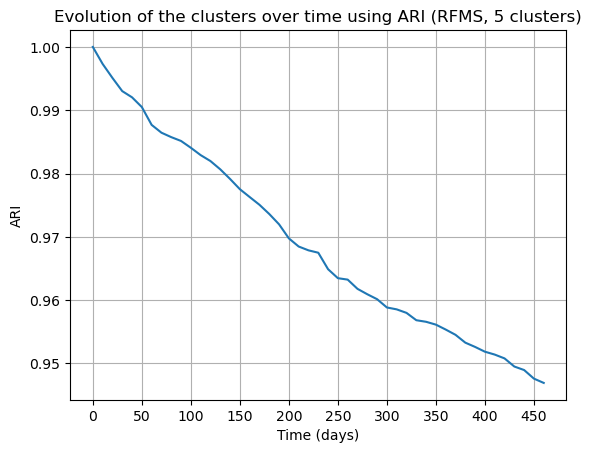

In [11]:
plt.plot(timerange, ARI)
plt.ylabel('ARI')
plt.xlabel('Time (days)')
plt.title('Evolution of the clusters over time using ARI (RFMS, 5 clusters)')
plt.xticks(np.arange(0, maxrecency-medrecency, 50))

plt.grid()
plt.show()

The Adjusted Rand Index seems to folow a linear diminition over time. Therefore we recomande a maintenance every 200 days in order to keep an ARI > 0.97 to better monitor the change of customer's behavior.   